In [20]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
from scipy.stats import linregress

In [21]:
data_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project"
project = signac.get_project(data_path)

In [8]:
state_dict={"size": "small", 
            "process": "quench", 
            "kT_reduced":0.8, 
            "density":0.6}
job_path= project.find_jobs(state_dict)
job_list= project.find_jobs(state_dict)
#specify file type
for job in job_path:
    msd_path= job.fn('msd.log')
    rdf_path = job.fn('trajectory.gsd')
    

In [24]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions


def rdf_from_gsd(job, atom_types='all', r_max=5, r_min=0.5, nbins=50, start=100):
    gsd_file = "{}/trajectory.gsd".format(job.workspace())
    f = gsd.pygsd.GSDFile(open(gsd_file, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        if atom_types == 'all':
            freud_rdf.compute(frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset=False)
            for job in job_path:
                job_rdf = rdf_from_gsd(job, atom_types= ['f'])
                x = freud_rdf.bin_centers
                y = freud_rdf.rdf
                filename = 'data_files/{}{}mer-{}kT-{}den{}_{}_{}_rdf.txt'.format
                np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
                f.close()
                return freud_rdf, x, y

def msd_slope(job_path, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job_path, names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, y)
    plt.plot(x, x*slope + intercept, linestyle = 'dotted')
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    plt.show()         
    return x, y, slope, intercept
    

In [25]:
def get_rdf_data(file, rdf_type):
    data = np.genfromtxt(file, names=True, delimiter=',')
    x = data['{}_x'.format(rdf_type)]
    y = data['{}_y'.format(rdf_type)]
    return x,y


def data_analysis(job_list):
    for job in job_list:
        #print(job.ws)
        if msd_path:
            x, y, slope, intercept = msd_slope(msd_path)
        elif rdf_path:
            freud_rdf, x, y = rdf_from_gsd(rdf_path)
            #job_rdf = rdf_from_gsd(job, atom_types= ['f'])
            #x = rdf_results.bin_centers
            #y = rdf_results.rdf
            #txt_file = "{}/rdf-data.txt".format(job.workspace())  
            #np.savetxt(txt_file, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
        


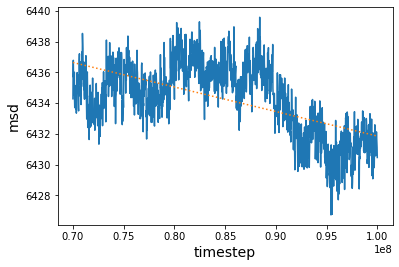

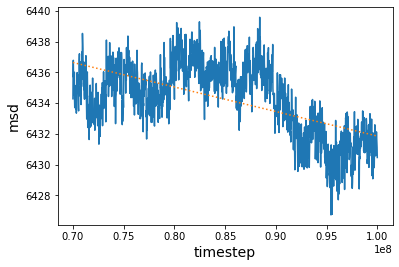

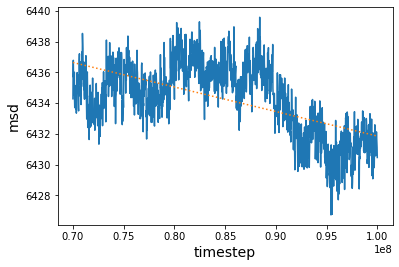

In [26]:
#job_selected= project.find_jobs(state_dict)
data_analysis(job_list)